## Simple Four-Feature-Spaces Tutorial

In this tutorial, we will work through an simple, artificial ML problem to illustrate the full `Pyreal` workflow, including four unique feature spaces and multiple explanation types.

Throughout this tutorial, imagine that we are Trinket Sellers looking to price new Trinkets based on five peices of information, as described below. We are working with ML model developers who will help us train a simple model to predict prices, but we would also like some explanations to help us understand how these predictions come from the five peices of information. As you will see, Pyreal can help!


### Problem Setup

We will be predicting Trinket prices based on five peices of information:
1. Trinket Type `type` (categorical)
2. Trinket Color `color` (categorical)
3. Trinket Age `age` (integer)
4. Trinket Weight `width` (float)
4. Trinket Height `height` (float)

This information can be formatted in multiple ways - each of these introduces a new *feature space*. In this tutorial, we will go over how you can use Pyreal Explainers and Transformers to play with these four feature spaces.

### Original Feature Space

In this example, we have been given the data in what we will refer to as the **original** feature space, or `X_orig`. This is an arbitrary feature space, that includes the information in whatever form our data-collection team happened to use. Let's load in and take a look at this space now.

We see that we have seven columns, one each for items 1 through 4 above, plus three one-hot encoded columns for the `type` feature, which encodes three possible categories - `foo`, `bar`, and `foobar`. The color feature is listed using HTML color codes, which are not very understandable. The other three features are numeric, as expected.

In [1]:
import pandas as pd

data_orig =  pd.read_csv("trinket_data.csv", index_col=0)
y_orig = data_orig["price"]
X_orig = data_orig.drop("price", axis=1)

print("Original feature space:")
X_orig.head()

Original feature space:


,color,age,width,height,type_bar,type_foo,type_foobar
0,#e51e32,41,43.569090,68.784567,1.0,0.0,0.0
1,#f51a2f,71,84.261218,60.542412,0.0,0.0,1.0
2,#21e308,90,71.574072,45.595469,1.0,0.0,0.0
3,#0630cf,32,23.125698,83.431874,0.0,1.0,0.0
4,#04d82b,44,54.253466,20.646017,0.0,0.0,1.0


### Model-Ready Feature Space

Let's go ahead and train a model to predict the price variable from the features. To do so, we will first need to transform the data to a model-ready standpoint. Our ML development team has done their research and feature engineering, and suggested that a simple linear regression model may work well. They have also collected the following domain knowledge that may be useful for feature engineering:
1. All trinkets are generally "reddish" or "blueish" - this is much more important to their price than the exact HTML color value.
2. Bigger trinkets sell for more - but the difference between width and height is arbitrary. In fact, only the larger of these axis matter

Based on this information, combined with the requirements of a linear regression model, let's put together some transformers using Pyreal's `transformer` package, and take a look at what the model-ready feature space looks like. As you can see, this feature space includes one-hot encoded and aggregated features.

We will use some pre-defined Pyreal transformers, that cover common transformation types, and also define some of our own using the Transformer base class, such as converting HTML colors codes to `red` and `blue`.

Note that Pyreal transformers take three flags: `model`, `interpret`, and `algorithm`. For now, we are just using the former. By setting `model` to `True`, we are telling Pyreal Explainers that these transformers are required to get the data to the feature space expected by the model. Note that `model==True` is the default flag; for the purposes of being clear in this tutorial, we are setting it explicitly.

In [2]:
from pyreal.transformers import Transformer, OneHotEncoder, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from pyreal.transformers import fit_transformers, run_transformers


def hex_to_color_name(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return ["red", "green", "blue"][rgb.index(max(rgb))]

class ColorTransformer(Transformer):
    """
    Transforms a hex color to `red` or `blue`
    """
    def __init__(self, columns, **kwargs):
        self.columns = columns
        super().__init__(**kwargs)

    def fit(self, x):
        return self

    def data_transform(self, x):
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x

class MaxAggregator(Transformer):
    """
    Converts a set of numeric features to a single feature of the max value
    """
    def __init__(self, columns, **kwargs):
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x


colorTransformer = ColorTransformer(columns = ["color"], model=True)
colorEncoder = OneHotEncoder(columns = ["color"], model=True)
maxAggregator = MaxAggregator(columns=["width", "height"], model=True)
# The featureSelect transformer keeps the order of columns consistent,
#   which can be helpful with complex transformations
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar',
                                          'color_blue', 'color_green', 'color_red',
                                          'MAX(width,height)'], model=True)

model_transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect]
X_model = fit_transformers(model_transformers, X_orig)
print("Model ready feature space:")
X_model.head()

Model ready feature space:


,age,type_bar,type_foo,type_foobar,color_blue,color_green,color_red,"MAX(width,height)"
0,41,1.0,0.0,0.0,0.0,0.0,1.0,68.784567
1,71,0.0,0.0,1.0,0.0,0.0,1.0,84.261218
2,90,1.0,0.0,0.0,0.0,1.0,0.0,71.574072
3,32,0.0,1.0,0.0,1.0,0.0,0.0,83.431874
4,44,0.0,0.0,1.0,0.0,1.0,0.0,54.253466


And now let's train a model and check the score...

In [3]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_model[0:400], y_orig[0:400])
print("Model r-squared: %.4f" % model.score(X_model[401:], y_orig[401:]))

Model r-squared: 0.9998


Our model development team has confirmed that this model performs well - but we would like to know how its making its predictions. How are our features interacting to give a price? Let's address this question by generating a local explanation for the first item in our dataset, using the popular explanation algorithm SHAP:

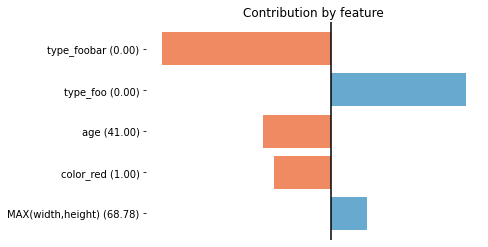

In [4]:
import shap
from pyreal.utils import visualize

explainer = shap.LinearExplainer(model, shap.maskers.Independent(data = X_model))
shap_values = explainer.shap_values(X_model[0:1])[0]
explanation = pd.DataFrame([shap_values], columns=X_model.columns)

visualize.plot_top_contributors(explanation, select_by="absolute",
                                values=X_model.iloc[0], show=True)


The explanation above can be hard to parse. The fact that the trinket is not of type `foobar` is greatly decreasing the predicted price; the fact that it is not of type `foo` is greatly increasing it. This level of granularity, including things like one-hot-encoded features, may be useful for some users - especially ML experts looking to work on the model itself. But what about other users, for example Trinket Sellers looking to use this model to help them decide on an appropriate Trinket price? Let's try some explanations presented in alternative ways.

### Interpretable feature space

There are some transforms we can apply to help. Our users want to see the features that actually contribute to the model prediction, but are confused when features are presented one-hot-encoded. Let's compile a few more transformers (from the original feature space again) - including some that were also useful for getting to the model-ready feature space. We'll take a look at the interpretable feature space.

We want to avoid one-hot encoded features, and present colors using English descriptions instead of HTML codes. Whether or not the explanation should include contributions from height and width separately versus the max aggregated feature is debatable - the former better matches the full information given, while the latter accurately describes how the model works. As we'll see in the next section, not all explanation types can accurately support all feature spaces, so that will factor into our choice as well.

To use a transformer in the interpretable feature space, we set its `interpret` flag to `True`. We can update existing transformers' flags using the `set_flags()` method.

We could make this space even more clear to human users with more descriptive feature names - but we'll add that in later.

In [5]:
mappings = Mappings.generate_mappings(
    categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings, model=False, interpret=True)

colorTransformer.set_flags(interpret=True)
maxAggregator.set_flags(interpret=True)
interpretable_transformers = [typeDecoder, colorTransformer, maxAggregator]

X_interpret = fit_transformers(interpretable_transformers, X_orig)
print("Interpretable feature space:")
X_interpret.head()

Interpretable feature space:


,color,age,type,"MAX(width,height)"
0,red,41,bar,68.784567
1,red,71,foobar,84.261218
2,green,90,bar,71.574072
3,blue,32,foo,83.431874
4,green,44,foobar,54.253466


### Algorithm-ready Feature Space

Many existing explanation algorithm implementations can't just take data in the interpretable form to produce an interpretable explanation - they have their own requirements for their input feature space.

Pyreal handles the details of transforming both data and explanations between feature spaces, using its `Explainer` classes, which take in a `transformer` list parameter, and through the Transformer flags. Let's see how that works, and once again generate a local SHAP contribution explanation.

The first thing we need to do is identify what feature space is required by the explanation type we'd like to use. We can take a look at the documentation for `ShapFeatureContribution` explainers to see that, in this case, the explanation algorithm expects data in the model-ready feature space. We can use the transformers we defined above, where those that take the data to the model-ready feature space have the flag `model=True`, and those that take the data to the interpretable feature space have the flag `interpret=True`.

We do need to be a bit careful with the order here. Pyreal calls the transformers' `.transform()` methods in the order listed, backtracking as needed to undo transformations on explanations.

In [6]:
from pyreal.explainers import ShapFeatureContribution

transformers = [maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder]

explainer = ShapFeatureContribution(model, X_orig,
                                    transformers=transformers,
                                    fit_on_init=True)

We can now produce and visualize an explanation

         age MAX(width,height)      color      type
0 -15.656246          8.279705 -20.622256 -8.060027
  color age type  MAX(width,height)
0   red  41  bar          68.784567


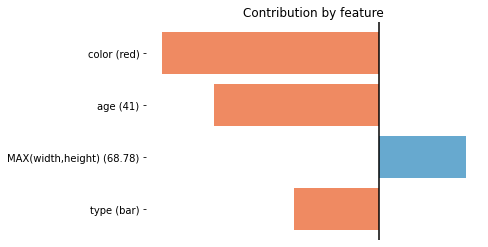

In [7]:
explanation, X_interpret = explainer.produce(X_orig.iloc[0])
print(explanation)
print(X_interpret)
visualize.plot_top_contributors(explanation, select_by="absolute",
                                values=X_interpret.iloc[0], show=True)

You may notice some warnings about missing transforms. It is not always possible to transform an explanation following a data transform - for example, in the case of MaxAggregator, we did not provide a way of distributing contribution between the features involved. Because of this, we will present our explanation using the aggregated features, to maintain explanation accuracy. We convert the data to the same interpretable state using the `i_transformers`.

Pyreal makes it easy to switch between different explanation algorithms. We can get another feature-contribution-based explanation using the `SimpleCounterfactualContribution` explainer. This explainer requires features in a different feature space, using categorical features. To address this, we'll use the `algorithm` flag. When transformers have `algorithm=False`, the transformation will not be run until a model prediction is needed. The explanation algorithm itself will receive data transformed only using transformers with `algorithm=True`.

In this case, the explanation generated has the height and width features un-aggregated, and so this is the most accurate output format. Because we decided either state could be interpretable, we will stick to the most accurate option.

Transformer <class '__main__.ColorTransformer'> does not have an implemented transform_explanation_additive_contributions function. Defaulting to no change in explanation. If this causes a break,you may want to add a interpret=False flag to this transformer or redefine this function to throw a BreakingTransformError.


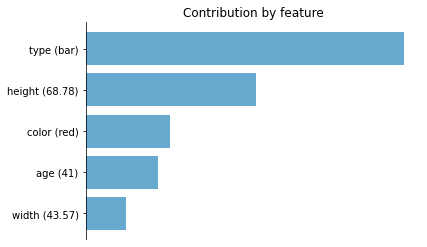

In [8]:
from pyreal.explainers import SimpleCounterfactualContribution

typeEncoder = OneHotEncoder(columns = ["type"])
fit_transformers([typeDecoder, typeEncoder], X_orig)

typeDecoder.set_flags(model=True, algorithm=True, interpret=True)
for transformer in [typeEncoder, maxAggregator, colorTransformer, colorEncoder, featureSelect]:
    transformer.set_flags(model=True, algorithm=False, interpret=False)
colorTransformer.set_flags(interpret=True)

explainer = SimpleCounterfactualContribution(model, X_orig,
                                             transformers=[typeDecoder, typeEncoder, maxAggregator, colorTransformer, colorEncoder, featureSelect],
                                             fit_on_init=True)

explanation, X_interpret = explainer.produce(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute",
                                values=X_interpret.iloc[0], show=True)

If we did want to get contributions of the aggregated features, we could do so without sacrificing accuracy by aggregating at the explanation level rather than the model-ready level, which is supported by this explanation type.

Transformer <class '__main__.ColorTransformer'> does not have an implemented transform_explanation_additive_contributions function. Defaulting to no change in explanation. If this causes a break,you may want to add a interpret=False flag to this transformer or redefine this function to throw a BreakingTransformError.


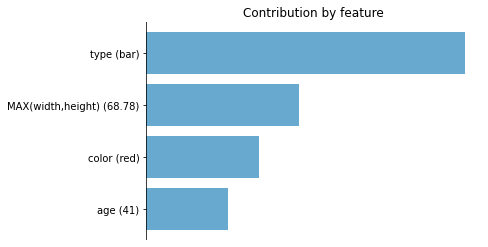

In [9]:
maxAggregator.set_flags(model=True, algorithm=True, interpret=True)
explainer = SimpleCounterfactualContribution(model, X_orig,
                                             transformers=[typeDecoder, maxAggregator, colorTransformer, colorEncoder, typeEncoder, featureSelect],
                                             fit_on_init=True)

explanation, X_interpret = explainer.produce(X_orig.iloc[0:1])
visualize.plot_top_contributors(explanation, select_by="absolute",
                                values=X_interpret.iloc[0], show=True)

We can also generate global feature-based explanations using the `gfi` package - for example, the `ShapFeatureImportance` explainer.

Transformer <class '__main__.ColorTransformer'> does not have an implemented inverse_transform_explanation_additive_contributions function. Defaulting to no change in explanation. If this causes a break,you may want to add an interpret=True flag to this transformer or redefine this function to throw a BreakingTransformError.


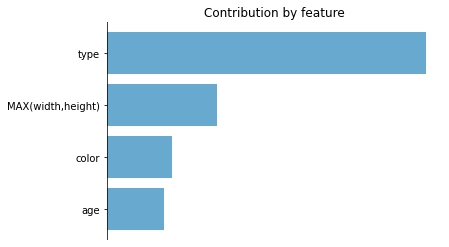

In [10]:
from pyreal.explainers import ShapFeatureImportance

for transformer in [colorTransformer, colorEncoder, featureSelect]:
    transformer.set_flags(model=True, algorithm=True, interpret=False)
typeDecoder.set_flags(model=False, algorithm=False, interpret=True)
maxAggregator.set_flags(model=True, algorithm=True, interpret=True)

explainer = ShapFeatureImportance(model, X_orig,
                                  transformers=[maxAggregator, colorTransformer, colorEncoder, featureSelect, typeDecoder],
                                  fit_on_init=True)

explanation = explainer.produce()
visualize.plot_top_contributors(explanation, select_by="absolute", show=True)